## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

Created for Coursera guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/learn/tweet-emotion-tensorflow)

---

## Task 1: Introduction


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [44]:
!pip install nlp

In [45]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.7.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [46]:
# LOAD DATASET
dataset = nlp.load_dataset('emotion') 

Using custom data configuration default


In [47]:
# The dataset has 3 splits ->train,test,validate
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [48]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [49]:
# Function to print the tweet
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [50]:
tweets, labels = get_tweets(train)

In [51]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [53]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

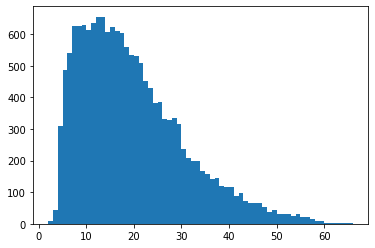

In [54]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [55]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 50 #chop off tweets larger than this , if smaller then pad

In [56]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [57]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [58]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [59]:
classes = set(labels)
print(classes)

{'love', 'surprise', 'anger', 'sadness', 'fear', 'joy'}


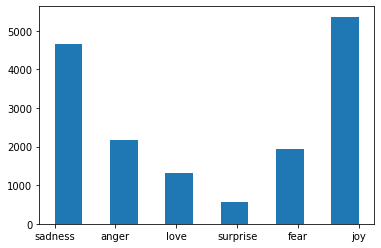

In [60]:
plt.hist(labels, bins=11)
plt.show()

In [61]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [62]:
classes_to_index

{'anger': 2, 'fear': 4, 'joy': 5, 'love': 0, 'sadness': 3, 'surprise': 1}

In [63]:
index_to_classes

{0: 'love', 1: 'surprise', 2: 'anger', 3: 'sadness', 4: 'fear', 5: 'joy'}

In [64]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [65]:
train_labels = names_to_ids(labels)
print(train_labels[0])

3


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [66]:
# Model -> LAYERS
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax') #because we have 6 output layer functions
])

# model compilation
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [67]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [68]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [69]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 12s 16ms/step - loss: 1.3426 - accuracy: 0.4707 - val_loss: 0.8303 - val_accuracy: 0.6930
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6053 - accuracy: 0.7604 - val_loss: 0.5707 - val_accuracy: 0.7955
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3415 - accuracy: 0.8814 - val_loss: 0.4421 - val_accuracy: 0.8525
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2286 - accuracy: 0.9262 - val_loss: 0.4013 - val_accuracy: 0.8730
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1709 - accuracy: 0.9455 - val_loss: 0.4136 - val_accuracy: 0.8755
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1396 - accuracy: 0.9563 - val_loss: 0.3619 - val_accuracy: 0.8880
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1105 - accuracy: 0.9655 - val_loss: 0.3669 - val_accuracy: 0.897

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

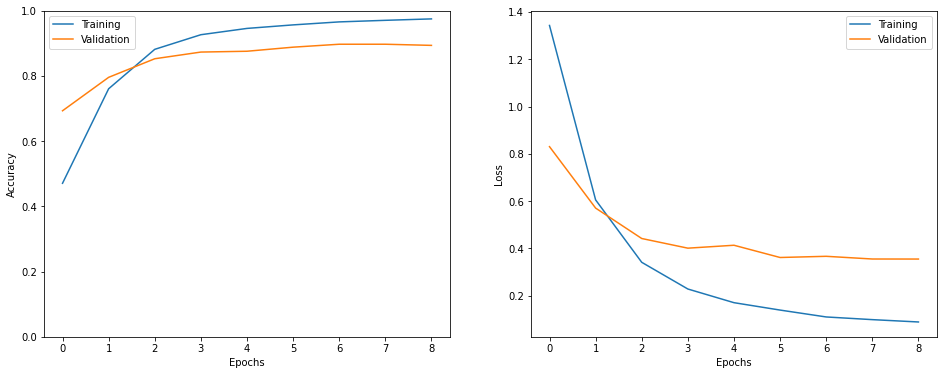

In [70]:
show_history(h)

In [71]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [72]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.3945 - accuracy: 0.8785


In [73]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
pred_class = index_to_classes[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: im feeling sentimental or in need of reassurance
Emotion: sadness
Predicted Emotion: sadness
